# Exercise 6: Firm growth with interactivity

## Section 1: Defining the model


1. **Partner Selection:** Firms interact if their relative size meets the following condition:
$$ \frac{1}{\delta} \cdot x_i \leq x_j \leq \delta \cdot x_i $$
When implementing this condition take the perspective of a firm looking for a partner.
Sampling two firms $i$ and $j$ from the population at random and checking the condition is very inefficient.


2. **Transaction Dynamics:** The winning probability in a transaction between firms $i$ and $j$ is:
$$ P(i \text{wins}) = \frac{x_i}{x_i + x_j} $$


3. **Resource Exchange:** Upon winning, "resources", i.e. part of their size are transferred from the loser to the winner. The amount of resources transferred is $ x_\text{loser} \gamma$ and  $\gamma \in [0, 1]$


In [2]:
import numpy as np
from mesa import Agent, Model
from mesa.time import RandomActivation
from mesa import DataCollector

In [45]:
import random


class Firm(Agent):
    """A Firm agent with a given size, part of an economic model."""

    def __init__(self, unique_id: int, model: "FirmModel", size: float):
        super().__init__(unique_id, model)
        self.size = size
        self.model = model

    def step(self) -> None:
        # your agent's actions
        interactive_firm = self.select_partner()
        if interactive_firm:
            my_win_prob = self.calculate_win_probability(interactive_firm)
            rnd = random.random()
            if rnd<=my_win_prob:
                interactive_firm.pay(self)
            else:
                self.pay(interactive_firm)

    def calculate_win_probability(self, partner: "Firm") -> float:
        # compute the win probability based on the size of the two firms
        if self.model.large_firm_advantage:
            return self.size/(self.size+partner.size)
        else:
            return partner.size/(self.size+partner.size)

    def pay(self, partner: "Firm") -> None:
        """Transfer a fraction of the firm's size to a partner firm."""
        partner.size+=self.model.gamma*self.size
        self.size-=self.model.gamma*self.size

    def select_partner(self) -> "Firm | None":
        """Select an other firm from the model that is within this firm's size interval (self) and return it."""
        valid_firms = [firm for firm in self.model.firms if self.size/firm.size > 1/self.model.delta and self.size/firm.size < self.model.delta]
        if len(valid_firms) == 0:
            return None
        else:
            return random.choice(valid_firms)


class FirmModel(Model):
    """A model simulating an economy with a variable number of firms."""

    def __init__(
        self,
        N: int,
        mu: float,
        sigma: float,
        delta: float,
        gamma: float,
        large_firm_advantage: bool = True,
    ):
        super().__init__()
        self.num_agents = N
        self.delta = delta
        self.gamma = gamma
        self.large_firm_advantage = large_firm_advantage
        self.schedule = RandomActivation(self)
        self.firms = []

        for i in range(self.num_agents):
            size = np.random.lognormal(mu, sigma)
            firm = Firm(i, self, size)
            self.schedule.add(firm)
            self.firms.append(firm)

        self.datacollector = DataCollector(
            agent_reporters={"Size": lambda a: a.size},
            model_reporters={"Firm_sizes": lambda m: m.firm_sizes()},
        )

    def firm_sizes(self) -> np.ndarray:
        return np.array([firm.size for firm in self.firms])

    def step(self) -> None:
        self.datacollector.collect(self)
        self.schedule.step()

## Section 2: Adapt the model such that the smaller firm has a higher winning probability.

In [ ]:
# your code here

## Run the simulation with the following parameters:

In [48]:
from tqdm import tqdm, trange
import random

# Example usage
N = 500  # Number of firms
m = 6.0  # Mean of the log-normal distribution
s = 1.5  # Standard deviation of the log-normal distribution
delta = 2  # Range factor for interaction
gamma = 0.1  # Size exchange in interactions

# set seed for reproducibility
np.random.seed(0)
random.seed(0)
model_winner_take_all = FirmModel(N, m, s, delta, gamma, large_firm_advantage=False)

for i in trange(500):
    model_winner_take_all.step()

100%|██████████| 500/500 [00:11<00:00, 42.76it/s]


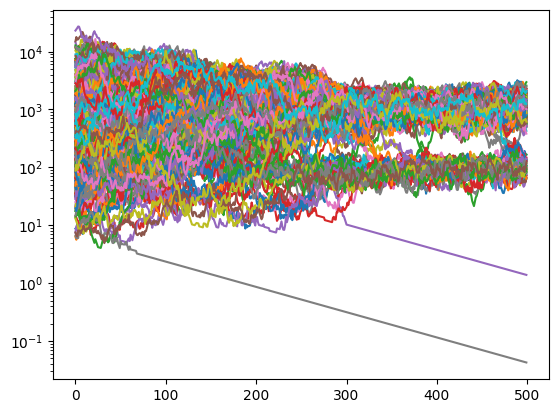

In [49]:
import matplotlib.pyplot as plt

firm_sizes = model_winner_take_all.datacollector.get_model_vars_dataframe()["Firm_sizes"].to_numpy()
firm_sizes = np.array([np.array(element) for element in firm_sizes])

plt.figure()
for i in range(len(firm_sizes[0])):
    plt.plot(firm_sizes[:,i])
plt.yscale("log")
plt.show()


## Section 3: Explore the parameter space and make interesting plots.

For example:
- Distribution of firm sizes on y and time on x axis
- Distribution of firm sizes on y and $\gamma$ on x axis
- Distribution of firm sizes on y and $\delta$ on x axis
- Distribution of firm sizes on y and $\sigma$ on x axis

In [ ]:
import matplotlib.pyplot as plt